# XGBOOST

### Import Necessary and Relevant Packages

In [1]:
%matplotlib inline

from IPython.display import display
from IPython.display import Image

import warnings
import os
warnings.filterwarnings('ignore')
from time import time
t00=time()

import theano
theano.config.optimizer='fast_compile'


import pandas as pd
import numpy as np
import xgboost as xgb
from hyperopt import fmin, hp, STATUS_OK, Trials, rand, anneal, tpe, mix, partial
from hp_gpsmbo import hpsuggest_ei
from hp_gpsmbo import hpsuggest_ucb
import matplotlib.pylab as plt

Mapped name None to device cuda: GeForce GTX 980 Ti
PCI Bus ID: 0000:01:00.0
Using cuDNN version 5105 on context None
/home/jd/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Import Data

In [2]:
credit_training = pd.read_csv('cs-training.csv')
credit_training_filled=credit_training.fillna(credit_training.median())
credit_training = credit_training.drop('Unnamed: 0', 1)

credit_test = pd.read_csv('cs-test.csv')
credit_test_filled=credit_test.fillna(credit_test.median())
credit_test = credit_test.drop('Unnamed: 0', 1)
credit_test = credit_test.drop('SeriousDlqin2yrs', 1)

y_training=credit_training['SeriousDlqin2yrs']
X_training=credit_training.loc[:,'RevolvingUtilizationOfUnsecuredLines':'NumberOfDependents']

y_training_filled=credit_training_filled['SeriousDlqin2yrs']
X_training_filled=credit_training_filled.loc[:,'RevolvingUtilizationOfUnsecuredLines':'NumberOfDependents']

X_test=credit_test.loc[:,'RevolvingUtilizationOfUnsecuredLines':'NumberOfDependents']

### Box-Cox Transformations

In [3]:
from scipy import stats

# training
X_training_BC=credit_training.loc[:,'RevolvingUtilizationOfUnsecuredLines':'NumberOfDependents']

x = X_training['age']+.0001
xt, _ = stats.boxcox(x)
X_training_BC['age']=xt

x = X_training['MonthlyIncome']+.0001
xt, _ = stats.boxcox(x)
X_training_BC['MonthlyIncome']=xt

x = X_training['RevolvingUtilizationOfUnsecuredLines']+.0001
xt, _ = stats.boxcox(x)
X_training_BC['RevolvingUtilizationOfUnsecuredLines']=xt



# test
X_test_BC=credit_test.loc[:,'RevolvingUtilizationOfUnsecuredLines':'NumberOfDependents']

x = X_test['age']+.0001
xt, _ = stats.boxcox(x)
X_test_BC['age']=xt

x = X_test['MonthlyIncome']+.0001
xt, _ = stats.boxcox(x)
X_test_BC['MonthlyIncome']=xt

x = X_test['RevolvingUtilizationOfUnsecuredLines']+.0001
xt, _ = stats.boxcox(x)
X_test_BC['RevolvingUtilizationOfUnsecuredLines']=xt

### Benchmark default hyperparameters

In [4]:
# init xgboost params
paramsDefault={'reg_alpha': 0,
               'colsample_bytree': 1,
               'colsample_bylevel': 1,
               'scale_pos_weight': 1,
               'learning_rate': 0.1,
               'base_score': .5,
               'n_estimators': 100,
               'subsample': 1,
               'reg_lambda': 1,
               'min_child_weight': 1,
               'eval_metric':'auc',
               'objective': 'binary:logistic',
               'max_depth': 3,
               'gamma': 0}

# load data into dmatrix
xgtrain = xgb.DMatrix(X_training, label=y_training)
xgtrain_bc = xgb.DMatrix(X_training_BC, label=y_training)

# 3-fold CV for both feature sets
modelcv=xgb.cv(paramsDefault, xgtrain, 100, nfold=3)
modelcv_bc=xgb.cv(paramsDefault, xgtrain_bc, 100, nfold=3)

# 10-fold CV for both feature sets
modelcv10=xgb.cv(paramsDefault, xgtrain, 100, nfold=10)
modelcv_bc10=xgb.cv(paramsDefault, xgtrain_bc, 100, nfold=10)

# print cv results
print '3-fold CV'
print 'Cross-Validation Results for NON-Box-Cox Transformed'
print modelcv.loc[99]
print '-'*57
print 'Cross-Validation Results for Box-Cox Transformed'
print modelcv_bc.loc[99]
print '#'*57
print '10-fold CV'
print 'Cross-Validation Results for NON-Box-Cox Transformed'
print modelcv10.loc[99]
print '-'*57
print 'Cross-Validation Results for Box-Cox Transformed'
print modelcv_bc10.loc[99]

3-fold CV
Cross-Validation Results for NON-Box-Cox Transformed
test-auc-mean     0.864002
test-auc-std      0.002083
train-auc-mean    0.870174
train-auc-std     0.001212
Name: 99, dtype: float64
---------------------------------------------------------
Cross-Validation Results for Box-Cox Transformed
test-auc-mean     0.863947
test-auc-std      0.002122
train-auc-mean    0.870002
train-auc-std     0.001127
Name: 99, dtype: float64
#########################################################
10-fold CV
Cross-Validation Results for NON-Box-Cox Transformed
test-auc-mean     0.864685
test-auc-std      0.008702
train-auc-mean    0.869142
train-auc-std     0.000999
Name: 99, dtype: float64
---------------------------------------------------------
Cross-Validation Results for Box-Cox Transformed
test-auc-mean     0.864683
test-auc-std      0.008704
train-auc-mean    0.869140
train-auc-std     0.000999
Name: 99, dtype: float64


### Fit benchmark models

In [5]:
#fit
model=xgb.train(paramsDefault, xgtrain, 100)
modelbc=xgb.train(paramsDefault, xgtrain_bc, 100)

### Plot Tree 1

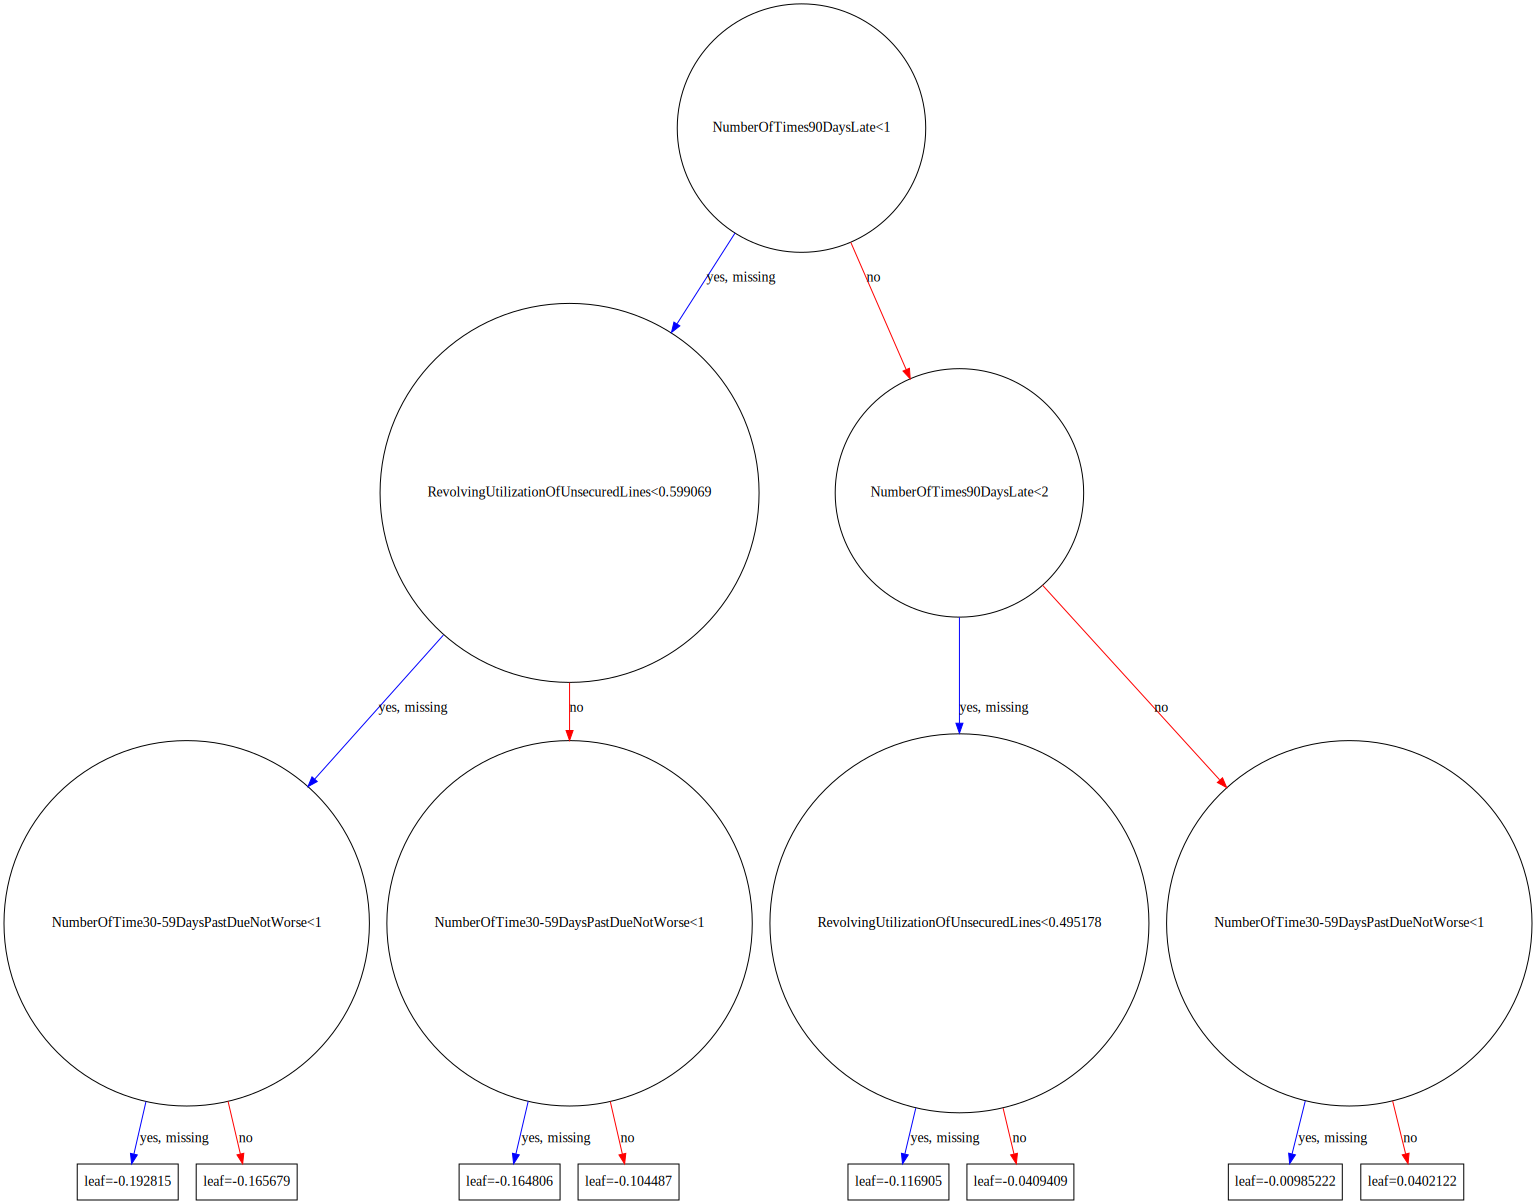

In [6]:
#plot tree
xgb.to_graphviz(model,num_trees=0)

### Plot Tree 2

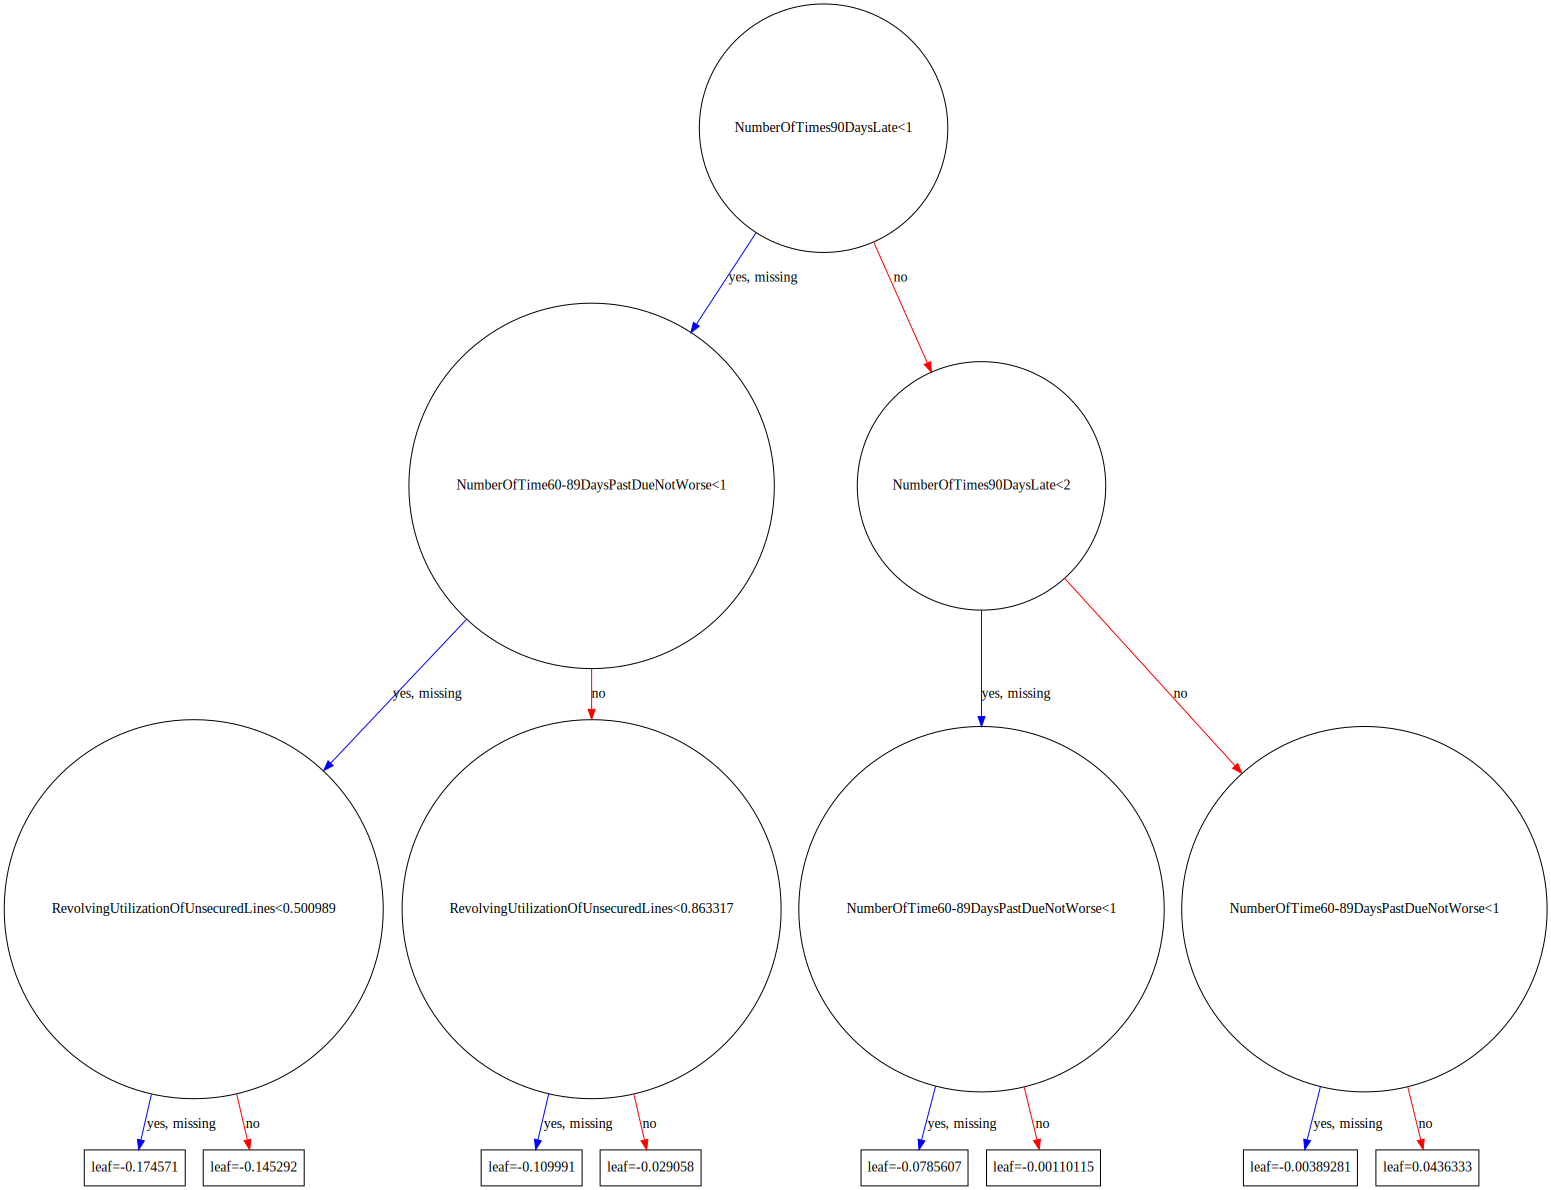

In [7]:
#plot tree
xgb.to_graphviz(model,num_trees=1)

### Plot Tree 3

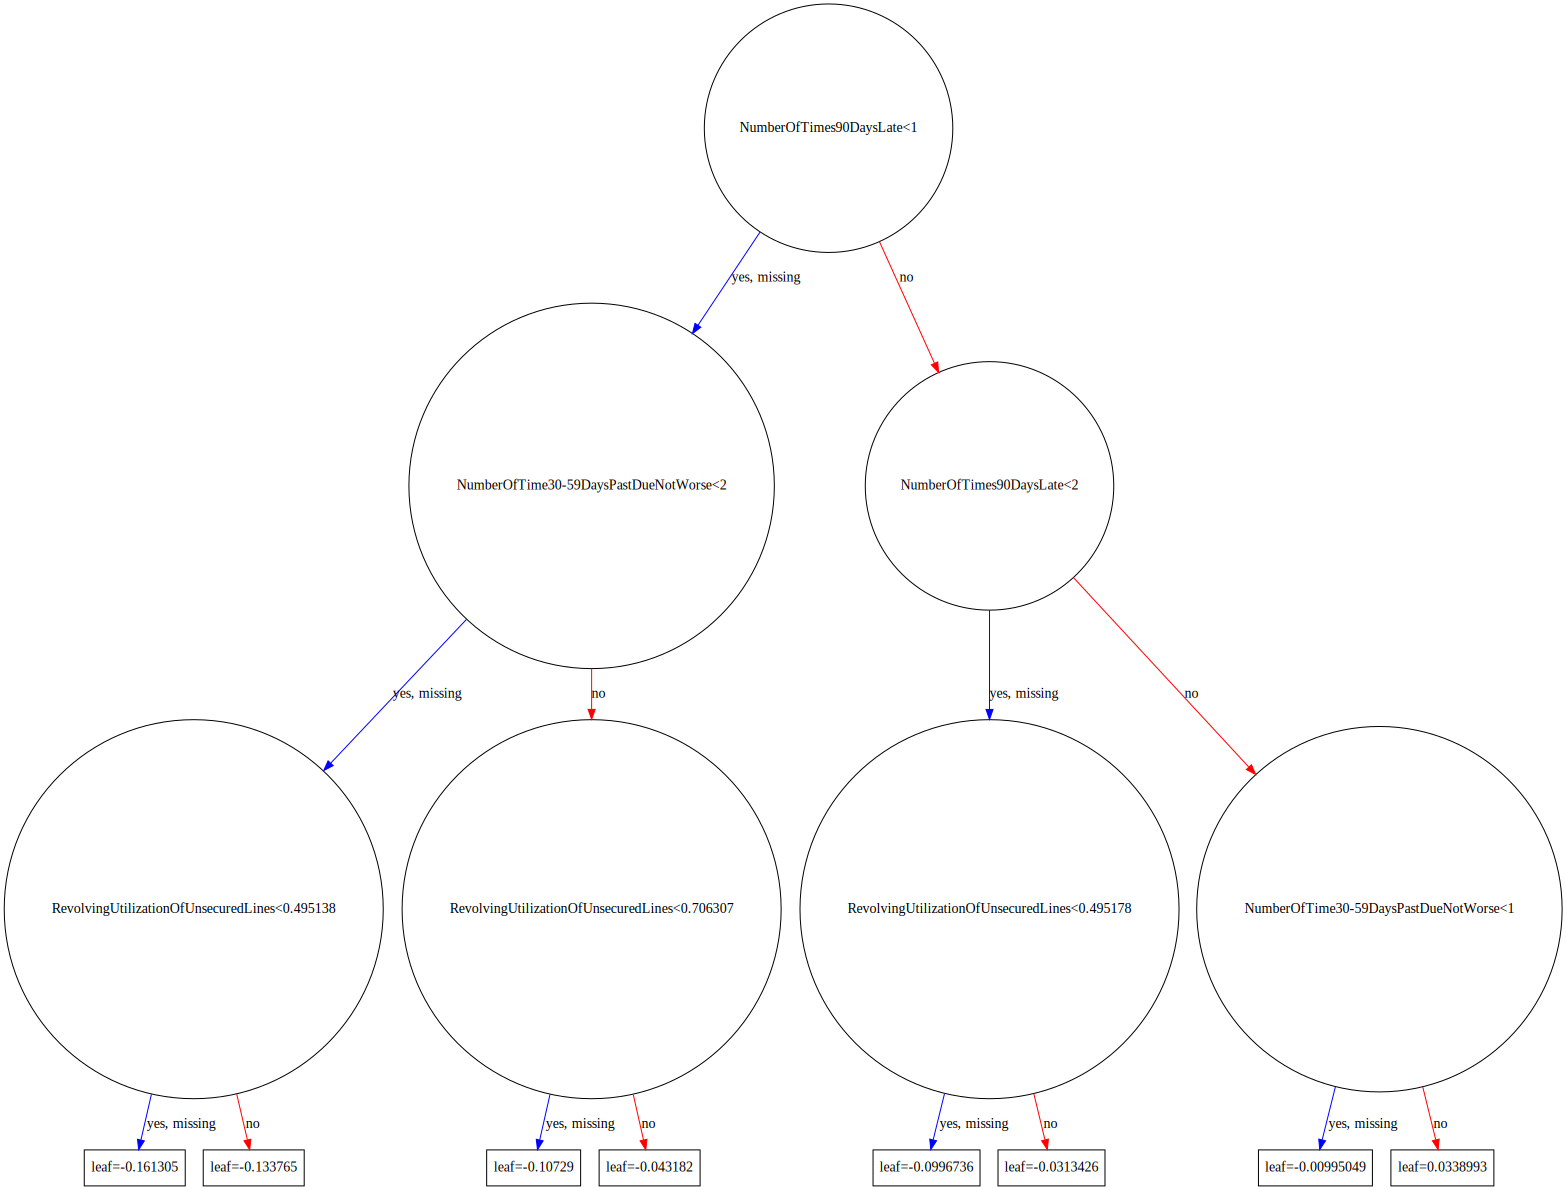

In [8]:
#plot tree
xgb.to_graphviz(model,num_trees=2)

### Plot Tree 4

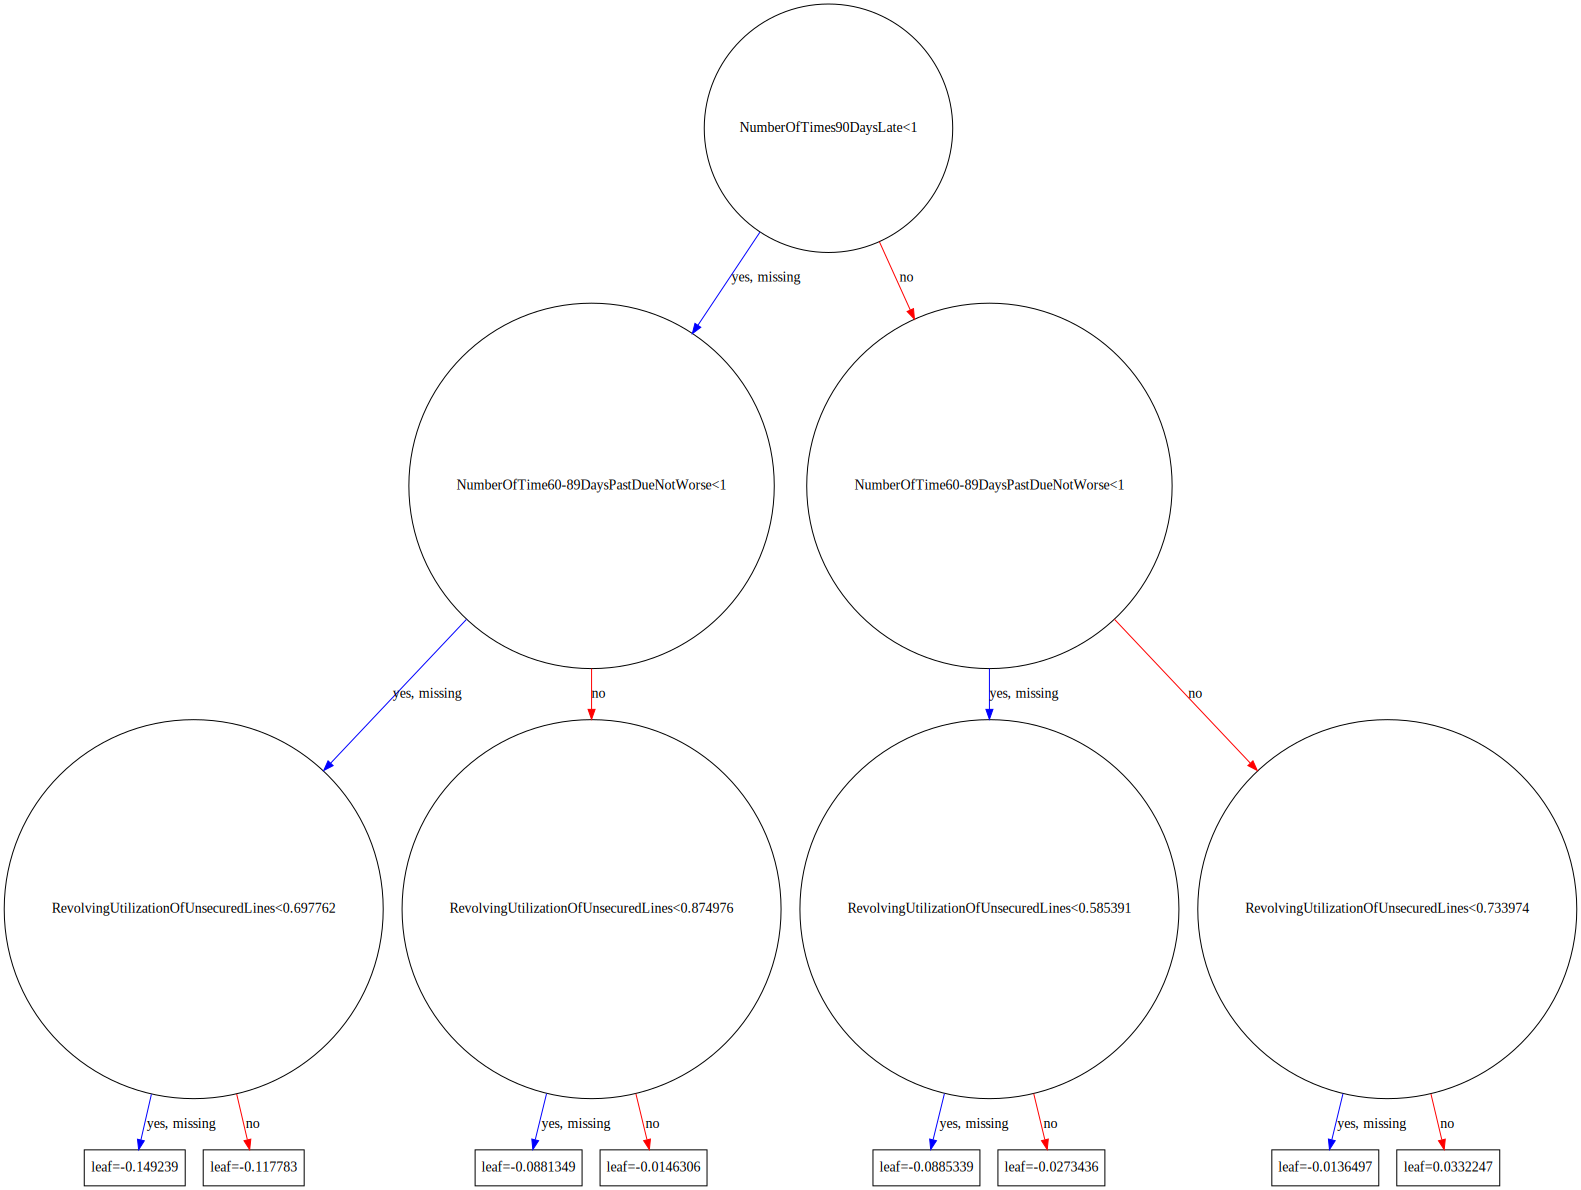

In [9]:
#plot tree
xgb.to_graphviz(model,num_trees=3)

### Make and Store Predictions for Submission

In [10]:
# make dmatrix
xgtest = xgb.DMatrix(X_test)

# predict and store unmodified X
pred=model.predict(xgtest)
submission = pd.DataFrame()
submission['Probability'] = pred
submission.to_csv('sub_v.csv')


# make dmatrix 
xgtest_bc = xgb.DMatrix(X_test_BC)

# predict and store Box-cox X
pred=modelbc.predict(xgtest_bc)
submission = pd.DataFrame()
submission['Probability'] = pred
submission.to_csv('sub_v_BC.csv')

In [11]:
print
print 'XGBoost, No Independent Variable Transformation'
XGBoost_url1 = 'http://i.imgur.com/Gymp03Q.jpg'
Image(url=XGBoost_url1)


XGBoost, No Independent Variable Transformation


In [12]:
print
print 'XGBoost, Box-Cox Independent Variable Transformation'
XGBoost_url2 = 'http://i.imgur.com/djgwXL3.jpg'
Image(url=XGBoost_url2)


XGBoost, Box-Cox Independent Variable Transformation


## Hyperopt

In [13]:
def hyperopt_train_test(params):
    params['eta']=.1
    try:
        modelcv=xgb.cv(params, xgtrain, 10000, nfold=3, early_stopping_rounds=75)
    except:
        return .85
    return modelcv.loc[np.size(modelcv,0)-1][0]

def hyperopt_train_test_BC(params):
    params['eta']=.1
    try:
        modelcv=xgb.cv(params, xgtrain_bc, 10000, nfold=3, early_stopping_rounds=75)
    except:
        return .85
    return modelcv.loc[np.size(modelcv,0)-1][0]

### Functions to be minimized

In [14]:
xs=[]
ys=[]          
best = .5
i=0
clfs=pd.DataFrame()   
def f(params):
    global i
    global best
    global clfs
    auc = hyperopt_train_test(params)

    i=i+1
    print 'Trial: ',i, ' AUC: ',auc

    xs.append(i)
    ys.append(auc)

    if auc > best:
        best = auc
        print 'New best:', auc
        print params
        print 'Trial: ', i
        print
        df = pd.DataFrame([[params, auc]], columns=['clf','score'])
        clfs=clfs.append(df)
        clfs.to_csv('clfscompare.csv')
        print time()-t00
        
    return {'loss': -auc, 'status': STATUS_OK}



  
def f_BC(params):
    global i
    global best
    global clfs
    auc = hyperopt_train_test_BC(params)

    i=i+1
    print 'Trial: ',i, ' AUC: ',auc

    xs.append(i)
    ys.append(auc)

    if auc > best:
        best = auc
        print 'New best:', auc
        print params
        print 'Trial: ', i
        print
        df = pd.DataFrame([[params, auc]], columns=['clf','score'])
        clfs=clfs.append(df)
        clfs.to_csv('clfscomparebc.csv')
        print time()-t00
        
    return {'loss': -auc, 'status': STATUS_OK}

### Space to explore

In [15]:
space4xg = {"max_depth": hp.choice('max_depth', range(4,15)),
          "min_child_weight": hp.choice('min_child_weight', range(1,270)),
          "gamma": hp.uniform('gamma',0,3),
          "colsample_bytree": hp.uniform('colsample_bytree', .95,1.0),
          "subsample": hp.uniform('subsample', .2,.9999),
          "lambda": hp.uniform('reg_lambda',0,52.7),
          "alpha": hp.uniform('reg_alpha',0,27),
          "scale_pos_weight":hp.uniform('scale_pos_weight',0.01,100),
          "base_score":hp.uniform('base_score',0.1,.9999),
          'colsample_bylevel':hp.uniform('colsample_bylevel', .1,.9999),
          'objective': hp.choice('objective', ['binary:logistic','binary:logitraw']),
          'eval_metric': hp.choice('eval_metric', ['auc'])}

### Initiate optimization for non-transform

In [16]:
trials = Trials()

# warm up
rng=np.random.RandomState(seed=0)
bt = fmin(f, space4xg, algo=rand.suggest , max_evals=15, trials=trials, rstate=rng)

bt = fmin(f, space4xg, algo=hpsuggest_ucb.suggest , max_evals=125, trials=trials,rstate=rng)

paramsBO=clfs.clf.iloc[-1]

print 'Best Estimator: ', paramsBO

Trial:  1  AUC:  0.863223
New best: 0.863223
{'colsample_bytree': 0.9850734317541101, 'eval_metric': 'auc', 'colsample_bylevel': 0.8615939601152381, 'scale_pos_weight': 68.57437462792714, 'base_score': 0.8169586947984625, 'subsample': 0.5887892536849382, 'eta': 0.1, 'min_child_weight': 240, 'objective': 'binary:logitraw', 'alpha': 5.281103074380008, 'max_depth': 13, 'gamma': 0.5414408921698582, 'lambda': 51.93985786986626}
Trial:  1

90.8750960827
Trial:  2  AUC:  0.861203333333
Trial:  3  AUC:  0.860710666667
Trial:  4  AUC:  0.864993
New best: 0.864993
{'colsample_bytree': 0.9704286505924608, 'eval_metric': 'auc', 'colsample_bylevel': 0.8336444106510245, 'scale_pos_weight': 5.799205390916088, 'base_score': 0.3903688930191075, 'subsample': 0.6229005244861532, 'eta': 0.1, 'min_child_weight': 156, 'objective': 'binary:logitraw', 'alpha': 5.169572333578733, 'max_depth': 9, 'gamma': 1.9262238318618334, 'lambda': 18.03833777097961}
Trial:  4

137.042526007
Trial:  5  AUC:  0.86221
Trial:  

### Initiate Box-COx transformed fit optimization

In [17]:
# reset
xs=[]
ys=[]          
best = .5
i=0
clfs=pd.DataFrame() 


trials_BC = Trials()

# warm up
rng=np.random.RandomState(seed=0)
btBC = fmin(f_BC, space4xg, algo=rand.suggest , max_evals=15, trials=trials_BC, rstate=rng)

btBC = fmin(f_BC, space4xg, algo=hpsuggest_ucb.suggest , max_evals=125, trials=trials_BC,rstate=rng)

paramsBOBC=clfs.clf.iloc[-1]

print 'Best Estimator: ', paramsBOBC

Trial:  1  AUC:  0.863285
New best: 0.863285
{'colsample_bytree': 0.9850734317541101, 'eval_metric': 'auc', 'colsample_bylevel': 0.8615939601152381, 'scale_pos_weight': 68.57437462792714, 'base_score': 0.8169586947984625, 'subsample': 0.5887892536849382, 'eta': 0.1, 'min_child_weight': 240, 'objective': 'binary:logitraw', 'alpha': 5.281103074380008, 'max_depth': 13, 'gamma': 0.5414408921698582, 'lambda': 51.93985786986626}
Trial:  1

2352.47539687
Trial:  2  AUC:  0.861242
Trial:  3  AUC:  0.860682333333
Trial:  4  AUC:  0.864993666667
New best: 0.864993666667
{'colsample_bytree': 0.9704286505924608, 'eval_metric': 'auc', 'colsample_bylevel': 0.8336444106510245, 'scale_pos_weight': 5.799205390916088, 'base_score': 0.3903688930191075, 'subsample': 0.6229005244861532, 'eta': 0.1, 'min_child_weight': 156, 'objective': 'binary:logitraw', 'alpha': 5.169572333578733, 'max_depth': 9, 'gamma': 1.9262238318618334, 'lambda': 18.03833777097961}
Trial:  4

2399.307019
Trial:  5  AUC:  0.8619483333

### Find optimal number of estimators

In [18]:
modelcvBO=xgb.cv(paramsBO, xgtrain, 10000, nfold=10, early_stopping_rounds=125)
modelcvBOBC=xgb.cv(paramsBOBC, xgtrain_bc, 10000, nfold=10, early_stopping_rounds=125)

# print cv results
print '10-fold CV'
print 'Cross-Validation Results for NON-Box-Cox Transformed'
print modelcvBO.iloc[-1]
print '-'*57
print 'Cross-Validation Results for Box-Cox Transformed'
print modelcvBOBC.iloc[-1]

10-fold CV
Cross-Validation Results for NON-Box-Cox Transformed
test-auc-mean     0.866842
test-auc-std      0.008541
train-auc-mean    0.877029
train-auc-std     0.000964
Name: 146, dtype: float64
---------------------------------------------------------
Cross-Validation Results for Box-Cox Transformed
test-auc-mean     0.866553
test-auc-std      0.008509
train-auc-mean    0.874583
train-auc-std     0.000951
Name: 122, dtype: float64


### Fit Optimized Models

In [19]:
#fit
model=xgb.train(paramsBO, xgtrain, np.size(modelcvBO,0))
modelbc=xgb.train(paramsBOBC, xgtrain_bc, np.size(modelcvBOBC,0))

### Plot Tree

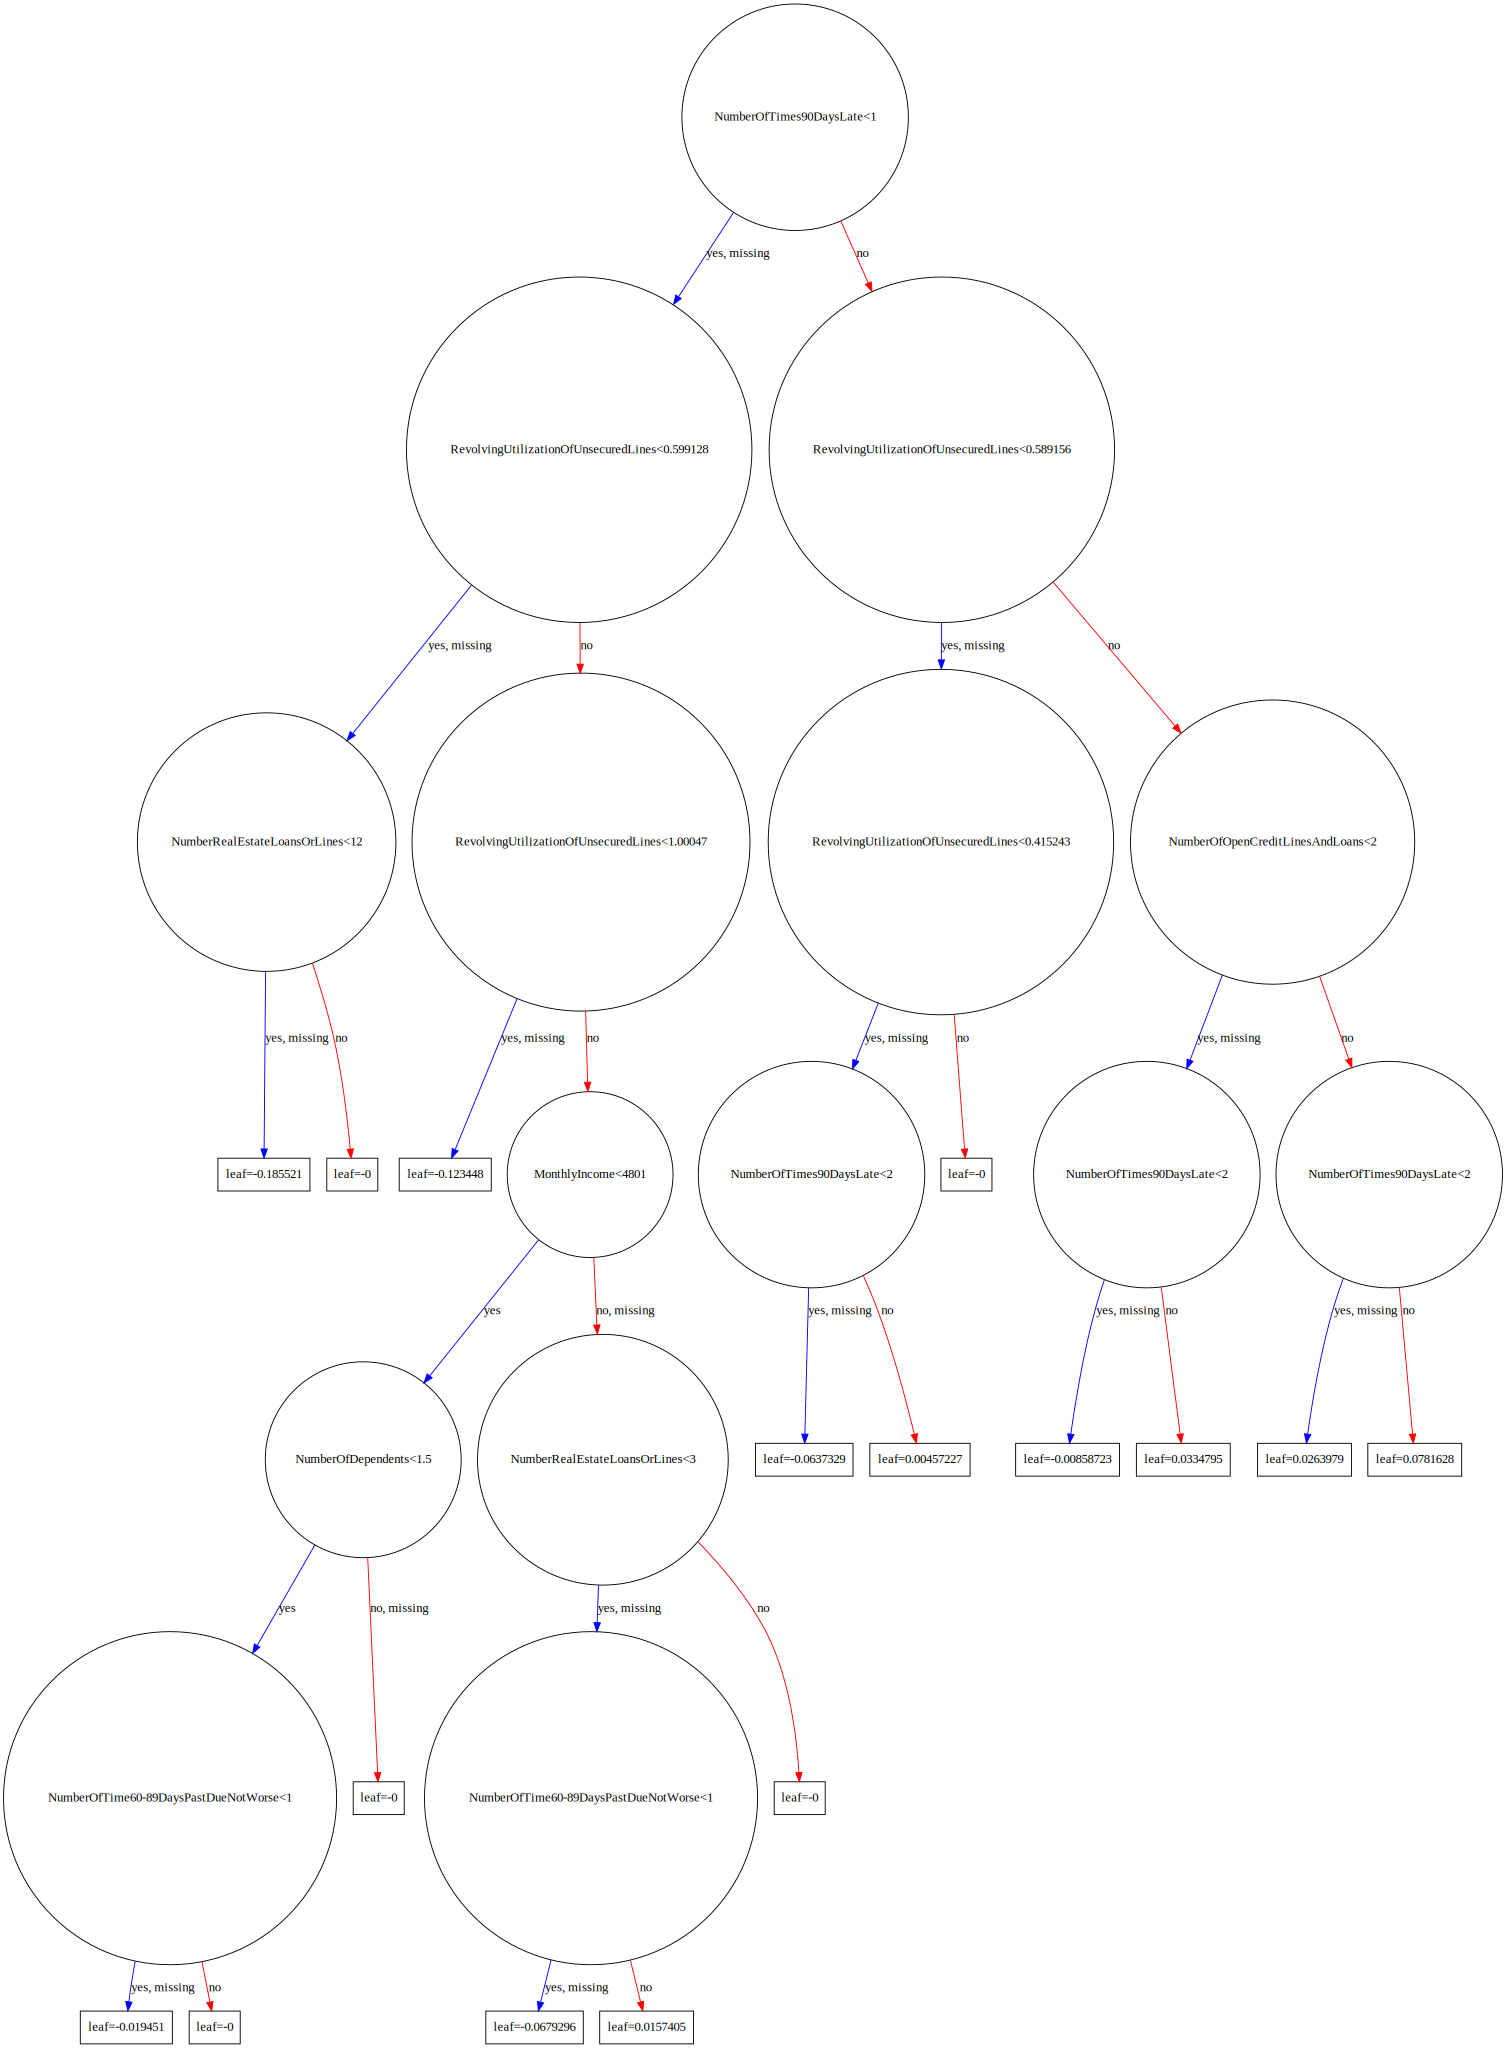

In [20]:
xgb.to_graphviz(model,num_trees=0)

### Make and Store Submissions

In [21]:
# predict and store unmodified X
pred=model.predict(xgtest)
submission = pd.DataFrame()
submission['Probability'] = pred
submission.to_csv('sub_v.csv')


# predict and store Box-cox X
pred=modelbc.predict(xgtest_bc)
predp=np.exp(pred)/(1+np.exp(pred))
submission = pd.DataFrame()
submission['Probability'] = predp
submission.to_csv('sub_v_BC.csv')

In [22]:
print
print 'XGBoost Optimized, No Independent Variable Transformation'
XGBoost_url3= 'http://i.imgur.com/uPNAuUF.jpg'
Image(url=XGBoost_url3)


XGBoost Optimized, No Independent Variable Transformation


In [23]:
print
print 'XGBoost Optimized, Box-Cox Independent Variable Transformation'
XGBoost_url4 = 'http://i.imgur.com/M39CJOD.jpg'
Image(url=XGBoost_url4)


XGBoost Optimized, Box-Cox Independent Variable Transformation
